Acknowledgement. This colab notebook is based on [Visual Anagrams](https://github.com/dangeng/visual_anagrams), [Stable Diffusion](https://github.com/fastai/diffusion-nbs) and [PyTV-4D](https://github.com/eboigne/PyTV-4D).

In [ ]:
# @title #Install requirements { display-mode: "code" }
!pip install -q --upgrade transformers diffusers ftfy mediapy

from base64 import b64encode

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

import numpy as np
import matplotlib.pyplot as plt
import mediapy as mp
import cv2
import pywt

from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# @title #Load Models
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=torch.float16)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# Helper Functions

In [ ]:
#@title #Tensor Helpers
def tensor_to_numpy(tensor):
    # Move tensor to CPU and convert to float32 NumPy
    return tensor.detach().cpu().numpy().astype(np.float32)

def numpy_to_tensor(array, device):
    # Convert NumPy array back to tensor, convert to float16, and move to specified device
    return torch.tensor(array, dtype=torch.float16).to(device)

In [ ]:
#@title #Fourier Helpers
def fourier_denoising(im, percent):
    # percent is the percentage of DFT coeffs we would like to keep, from 0-100
    # Denoising a H x W image on GPU, handling float16 data type
    im_float = im.to(torch.float32)  # Convert to float32 for FFT
    f = torch.fft.fft2(im_float)
    thres = torch.quantile(f.abs(), 1 - percent / 100)
    filtered_f = torch.where(f.abs() >= thres, f, torch.zeros_like(f))
    recons = torch.fft.ifft2(filtered_f)
    return recons.real.to(torch.float16)  # Convert back to float16

def fourier_denoising_channelwise(im, percent):
    # percent is the percentage of DFT coeffs we would like to keep, from 0-100
    # Denoising a C x H x W image independently for each channel on GPU, handling float16
    C, H, W = im.shape
    recons = torch.empty_like(im)
    for i in range(C):
        recons[i, :, :] = fourier_denoising(im[i, :, :], percent)
    return recons

def fourier_denoising_cross_channel(im, percent):
    # Denoising a C x H x W image by integrating all channels on GPU, handling float16
    C, H, W = im.shape
    f = torch.empty_like(im, dtype=torch.complex64)
    recons = torch.empty_like(im)
    for i in range(C):
        f[i, :, :] = torch.fft.fft2(im[i, :, :].to(torch.float32))  # Convert to float32 for FFT
    thres = torch.quantile(f.abs(), 1 - percent / 100)
    filtered_f = torch.where(f.abs() >= thres, f, torch.zeros_like(f))
    for i in range(C):
        recons[i, :, :] = torch.fft.ifft2(filtered_f[i, :, :]).real.to(torch.float16)  # Convert back to float16
    return recons




In [ ]:
#@title #Wavelet Helpers
def coeffs2img(LL, coeffs):
  # format the coeffs returned by pywt.wavedec2 to a matrix
  LH, HL, HH = coeffs
  return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))

def unstack_coeffs(Wim):
  # intermedia step for convert the coeffs matrix in the right form of the input of pywt.waverec2
  L1, L2  = np.hsplit(Wim, 2)
  LL, HL = np.vsplit(L1, 2)
  LH, HH = np.vsplit(L2, 2)
  return LL, [LH, HL, HH]

def img2coeffs(Wim, levels=4):
  # convert the coeffs matrix in the right form of the input of pywt.waverec2
  LL, c = unstack_coeffs(Wim)
  coeffs = [c]
  for i in range(levels-1):
    LL, c = unstack_coeffs(LL)
    coeffs.insert(0,c)
  coeffs.insert(0, LL)
  return coeffs

def dwt2(im):
  coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=4)
  Wim, rest = coeffs[0], coeffs[1:]
  for levels in rest:
    Wim = coeffs2img(Wim, levels)
  return Wim

def idwt2(Wim):
  coeffs = img2coeffs(Wim, levels=4)
  return pywt.waverec2(coeffs, wavelet='db4', mode='per')

def wavelet_denoising(im, percent):
  # percent is the percentage of coeffs we would like to keep, value from 0-1
  Wim = dwt2(im)
  m = np.sort(abs(Wim.ravel()))[::-1]
  ndx = int(len(m)*percent)
  thres = m[ndx]
  Wim_thr = np.sign(Wim)*np.maximum(np.abs(Wim)-thres,0) # soft-thresholding
  im_recon_thr = idwt2(Wim_thr)
  return im_recon_thr


def wavelet_denoising_channelwise(im, percent):
  # percent is the percentage of coeffs we would like to keep, value from 0-1
  # denoisng a C x H x W image independent of each channel
  C, H, W = im.shape
  recons = im.copy()
  for i in range(C):
    recons[i,:,:] = wavelet_denoising(im[i,:,:], percent)
  return recons


def wavelet_process(tensor, percent, device='cuda'):
  # percent is the percentage of DWT coeffs we would like to keep, value from 0-1
    # Step 1: Convert tensor to NumPy and ensure dtype is float32
    im_np = tensor_to_numpy(tensor)

    # Step 2: Perform wavelet denoising
    im_np_denoised = wavelet_denoising_channelwise(im_np, percent)

    # Step 3: Convert back to PyTorch tensor on GPU
    tensor_denoised = numpy_to_tensor(im_np_denoised, device)

    return tensor_denoised


In [ ]:
#@title #TV Helpers (function related to total variance and proximal GD, PyTV-4D package)
def compute_L21_norm(D_img, return_array = False):
    '''
    Compute the L2,1 norm of an image of discrete differences: |x|_2,1 = \sum_i \sqrt(\sum_j x_{i,j}^2),
    with index i summing over image pixels, slices, and times, while index j is summing over the difference terms.
    Usage: TV(img) = reg * compute_L21_norm(D(img))

    Parameters
    ----------
    D_img : np.ndarray
        The numpy array of the discrete gradient of dimensions Nz x Nd x M x N x N.
    return_array : boolean
        Whether to return the array of the L2 norms.

    Returns
    -------
    l21_norm : float
        The value of the L2,1 norm.
    out : np.ndarray
        An array of the L2 norms of size Nz x M x N x N.
    '''

    out = np.square(D_img)
    out = np.sum(out, axis = 1)
    out = np.sqrt(out)
    l21_norm = np.sum(out)

    if return_array:
        return(l21_norm, out)
    else:
        return(l21_norm)

def D_hybrid(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D (gradient discretized using hybrid scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D(img) of dimensions Nz x Nd x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    M = img.shape[1]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    N_d = 4
    if Nz > 1 and reg_z_over_reg > 0:
        N_d += 2
    if reg_time > 0 and M > 1:
        N_d += 2
    D_img = np.zeros([Nz, N_d, M, N, N], dtype = img.dtype)

    # The intensity differences across rows (Upwind / Forward)
    D_img[:, 0, :, :-1, :] = img[:, :, 1:, :] - img[:, :, :-1, :]

    # The intensity differences across columns (Upwind / Forward)
    D_img[:, 1, :, :, :-1] = img[:, :, :, 1:] - img[:, :, :, :-1]

    # The intensity differences across rows (Downwind / Backward)
    D_img[:, 2, :, 1:, :] = D_img[:, 0, :, :-1, :]

    # The intensity differences across columns (Downwind / Backward)
    D_img[:, 3, :, :, 1:] = D_img[:, 1, :, :, :-1]

    i_d = 4
    if Nz > 1 and reg_z_over_reg > 0:

        # The intensity differences across slices (Upwind / Forward)
        D_img[:-1, i_d, :, :, :] = sqrt_reg_z_over_reg * (img[1:, :, :, :] - img[:-1, :, :, :])
        i_d += 1

        # The intensity differences across z (Downwind / Backward)
        D_img[1:, i_d, :, :, :] = D_img[:-1, i_d-1, :, :, :]
        i_d += 1

    if reg_time > 0 and M > 1:

        # The intensity differences across times (Upwind / Forward)
        D_img[:, i_d, :-1, :, :] = sqrt_reg_time * (img[:, 1:, :, :] - img[:, :-1, :, :])

        # The intensity differences across time (Downwind / Backward)
        D_img[:, i_d+1, 1:, :, :] = D_img[:, i_d, :-1, :, :]

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, 2, M, N, N])
            D_img[:,i_d:i_d+2,:,:,:][mask_4D_broadcast] *= sqrt_factor_reg_static

        i_d += 2

    return (D_img/np.sqrt(2.0))

def D_downwind(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D (gradient discretized using downwind scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D(img) of dimensions Nz x Nd x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    M = img.shape[1]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    N_d = 2
    if Nz > 1 and reg_z_over_reg > 0:
        N_d += 1
    if reg_time > 0 and M > 1:
        N_d += 1

    D_img = np.zeros([Nz, N_d, M, N, N], dtype = img.dtype)

    # The intensity differences across rows (Downwind / Backward)
    D_img[:, 0, :, 1:, :] = (img[:, :, 1:, :] - img[:, :, :-1, :])

    # The intensity differences across columns (Downwind / Backward)
    D_img[:, 1, :, :, 1:] = (img[:, :, :, 1:] - img[:, :, :, :-1])

    i_d = 2
    if Nz > 1 and reg_z_over_reg > 0:
        # The intensity differences across z (Downwind / Backward)
        D_img[1:, i_d, :, :, :] = sqrt_reg_z_over_reg * (img[1:, :, :, :] - img[:-1, :, :, :])
        i_d += 1

    if reg_time > 0 and M > 1:
        # The intensity differences across time (Downwind / Backward)
        D_img[:, i_d, 1:, :, :] = sqrt_reg_time * (img[:, 1:, :, :] - img[:, :-1, :, :])

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, 1, M, N, N])
            D_img[:,i_d:i_d+1,:,:,:][mask_4D_broadcast] *= sqrt_factor_reg_static

        i_d += 1

    return D_img

def D_upwind(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D (gradient discretized using upwind scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D(img) of dimensions Nz x Nd x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    M = img.shape[1]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    N_d = 2
    if Nz > 1 and reg_z_over_reg > 0:
        N_d += 1
    if reg_time > 0 and M > 1:
        N_d += 1

    D_img = np.zeros([Nz, N_d, M, N, N], dtype = img.dtype)

    # The intensity differences across rows (Upwind / Forward)
    D_img[:, 0, :, :-1, :] = img[:, :, 1:, :] - img[:, :, :-1, :]

    # The intensity differences across columns (Upwind / Forward)
    D_img[:, 1, :, :, :-1] = img[:, :, :, 1:] - img[:, :, :, :-1]

    i_d = 2
    if Nz > 1 and reg_z_over_reg > 0:
        # The intensity differences across slices (Upwind / Forward)
        D_img[:-1, i_d, :, :, :] = sqrt_reg_z_over_reg * (img[1:, :, :, :] - img[:-1, :, :, :])
        i_d += 1

    if reg_time > 0 and M > 1:
        # The intensity differences across times (Upwind / Forward)
        D_img[:, i_d, :-1, :, :] = sqrt_reg_time * (img[:, 1:, :, :] - img[:, :-1, :, :])

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, 1, M, N, N])
            D_img[:,i_d:i_d+1,:,:,:][mask_4D_broadcast] *= sqrt_factor_reg_static

        i_d += 1

    return D_img

def D_central(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D (gradient discretized using central scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D(img) of dimensions Nz x Nd x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    M = img.shape[1]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    N_d = 2
    if Nz > 2 and reg_z_over_reg > 0:
        N_d += 1
    if reg_time > 0 and M > 1:
        N_d += 1

    D_img = np.zeros([Nz, N_d, M, N, N], dtype = img.dtype)

    # The intensity differences across rows
    D_img[:,0,:,1:-1,:] = (img[:,:, 2:,:] - img[:,:, :-2,:])

    # The intensity differences across columns
    D_img[:,1,:,:,1:-1] = (img[:,:,:,2:] - img[:,:,:,:-2])

    i_d = 2
    # The intensity differences across slices
    if Nz > 1 and reg_z_over_reg > 0:
        if Nz == 2: # Use upwind scheme instead
            D_img[:-1, i_d, :, :, :] = sqrt_reg_z_over_reg * (img[1:, :, :, :] - img[:-1, :, :, :])
        else:
            D_img[1:-1,i_d,:,:,:] = sqrt_reg_z_over_reg * (img[2:,:, :, :] - img[:-2,:, :, :])
        i_d += 1

    # The intensity differences across times
    if reg_time > 0 and M > 1:
        if M == 2: # Use upwind scheme instead
            D_img[:, i_d, :-1, :, :] = sqrt_reg_time * (img[:, 1:, :, :] - img[:, :-1, :, :])
        else:
            D_img[:,i_d,1:-1,:,:] = sqrt_reg_time * (img[:,2:,:,:] - img[:,:-2,:,:])

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, 1, M, N, N])
            D_img[:,i_d:i_d+1,:,:,:][mask_4D_broadcast] *= sqrt_factor_reg_static

        i_d += 1

    return (D_img / 2.0)

def D_T_hybrid(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D^T (tranposed gradient discretized using hybrid scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x Nd x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D^T(img) of dimensions Nz x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    Nd = img.shape[1]
    M = img.shape[2]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    D_T_img = np.zeros([Nz, M, N, N], dtype = img.dtype)


    # Forward row term
    D_T_img[:,:,1:,:] += img[:,0,:,:-1,:]
    D_T_img[:,:,:-1,:] += -img[:,0,:,:-1,:]

    # # Forward col term
    D_T_img[:,:,:,1:] += img[:,1,:,:,:-1]
    D_T_img[:,:,:,:-1] += -img[:,1,:,:,:-1]

    # Backward row term
    D_T_img[:,:,1:,:] += img[:, 2, :, 1:, :]
    D_T_img[:,:,:-1,:] += -img[:, 2, :, 1:, :]

    # Backward col term
    D_T_img[:,:,:,1:] += img[:, 3, :, :, 1:]
    D_T_img[:,:,:,:-1] += -img[:, 3, :, :, 1:]

    i_d = 4
    # The intensity differences across slices
    if Nz > 1 and reg_z_over_reg > 0:

        # Forward z terms
        D_T_img[1:,:,:,:] += sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
        D_T_img[:-1,:,:,:] += - sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
        i_d += 1

        # Backward z terms
        D_T_img[1:,:,:,:] += sqrt_reg_z_over_reg * img[1:, i_d,:,:,:]
        D_T_img[:-1,:,:,:] += -sqrt_reg_z_over_reg * img[1:, i_d,:,:,:]
        i_d += 1

    # The intensity differences across time
    if reg_time > 0 and M > 1:
        D_T_img_time_update = np.zeros_like(D_T_img, dtype = img.dtype)

        # Forward time terms
        D_T_img_time_update[:,1:,:,:] += sqrt_reg_time * img[:, i_d, :-1, :, :]
        D_T_img_time_update[:,:-1,:,:] += -sqrt_reg_time * img[:, i_d, :-1, :, :]
        i_d += 1

        # Backward time terms
        D_T_img_time_update[:, 1:, :, :] += sqrt_reg_time * img[:, i_d, 1:, :,:]
        D_T_img_time_update[:, :-1, :, :] += - sqrt_reg_time * img[:, i_d, 1:,:,:]
        i_d += 1

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, M, N, N])
            D_T_img_time_update[mask_4D_broadcast] *= sqrt_factor_reg_static

        D_T_img += D_T_img_time_update

    return(D_T_img/np.sqrt(2.0))

def D_T_downwind(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D^T (tranposed gradient discretized using downwind scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x Nd x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D^T(img) of dimensions Nz x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    Nd = img.shape[1]
    M = img.shape[2]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    D_T_img = np.zeros([Nz, M, N, N], dtype = img.dtype)

    # Backward row term
    D_T_img[:,:,1:,:] += img[:, 0, :, 1:, :]
    D_T_img[:,:,:-1,:] += -img[:, 0, :, 1:, :]

    # Backward col term
    D_T_img[:,:,:,1:] += img[:, 1, :, :, 1:]
    D_T_img[:,:,:,:-1] += -img[:, 1, :, :, 1:]

    i_d = 2
    # The intensity differences across slices
    if Nz > 1 and reg_z_over_reg > 0:
        D_T_img[1:,:,:,:] += sqrt_reg_z_over_reg * img[1:, i_d,:,:,:]
        D_T_img[:-1,:,:,:] += -sqrt_reg_z_over_reg * img[1:, i_d,:,:,:]
        i_d += 1

    # The intensity differences across time
    if reg_time > 0 and M > 1:
        D_T_img_time_update = np.zeros_like(D_T_img, dtype = img.dtype)

        D_T_img_time_update[:, 1:, :, :] += sqrt_reg_time * img[:, i_d, 1:, :,:]
        D_T_img_time_update[:, :-1, :, :] += - sqrt_reg_time * img[:, i_d, 1:,:,:]
        i_d += 1

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, M, N, N])
            D_T_img_time_update[mask_4D_broadcast] *= sqrt_factor_reg_static

        D_T_img += D_T_img_time_update

    return(D_T_img)

def D_T_upwind(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D^T (tranposed gradient discretized using upwind scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x Nd x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D^T(img) of dimensions Nz x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    Nd = img.shape[1]
    M = img.shape[2]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )
    D_T_img = np.zeros([Nz, M, N, N], dtype = img.dtype)

    # Forward row term
    D_T_img[:,:,1:,:] += img[:,0,:,:-1,:]
    D_T_img[:,:,:-1,:] += -img[:,0,:,:-1,:]

    # # Forward col term
    D_T_img[:,:,:,1:] += img[:,1,:,:,:-1]
    D_T_img[:,:,:,:-1] += -img[:,1,:,:,:-1]

    i_d = 2
    # The intensity differences across slices
    if Nz > 1 and reg_z_over_reg > 0:
        D_T_img[1:,:,:,:] += sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
        D_T_img[:-1,:,:,:] += - sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
        i_d += 1

    # The intensity differences across time
    if reg_time > 0 and M > 1:
        D_T_img_time_update = np.zeros_like(D_T_img, dtype = img.dtype)

        D_T_img_time_update[:,1:,:,:] += sqrt_reg_time * img[:, i_d, :-1, :, :]
        D_T_img_time_update[:,:-1,:,:] += -sqrt_reg_time * img[:, i_d, :-1, :, :]
        i_d += 1

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, M, N, N])
            D_T_img_time_update[mask_4D_broadcast] *= sqrt_factor_reg_static

        D_T_img += D_T_img_time_update

    return(D_T_img)

def D_T_central(img, reg_z_over_reg = 1.0, reg_time = 0, mask_static = False, factor_reg_static = 0):
    '''
    Calculates the output of the input image img by the operator D^T (tranposed gradient discretized using central scheme)

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x Nd x M x N x N.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.

    Returns
    -------
    np.ndarray
        The array of the discretized gradient D^T(img) of dimensions Nz x M x N x N.
    '''

    if reg_z_over_reg == np.nan:
        reg_z_over_reg = 0.0

    Nz = img.shape[0]
    N_d = img.shape[1]
    N = img.shape[-1]
    sqrt_reg_time = np.sqrt(reg_time )
    sqrt_reg_z_over_reg = np.sqrt(reg_z_over_reg )
    sqrt_factor_reg_static = np.sqrt(factor_reg_static )

    M = img.shape[2]
    D_T_img = np.zeros([Nz, M, N, N], dtype = img.dtype)

    # The intensity differences across rows
    D_T_img[:,:, 2:,:] += img[:,0,:,1:-1,:]
    D_T_img[:,:, :-2,:] += -img[:,0,:,1:-1,:]

    # The intensity differences across columns
    D_T_img[:,:, :,2:] += img[:,1,:,:,1:-1]
    D_T_img[:,:, :,:-2] += -img[:,1,:,:,1:-1]

    i_d = 2
    # The intensity differences across slices
    if Nz > 1 and reg_z_over_reg > 0:
        if Nz == 2: # Use upwind scheme instead
            D_T_img[1:,:,:,:] += sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
            D_T_img[:-1,:,:,:] += -sqrt_reg_z_over_reg * img[:-1, i_d, :, :, :]
        else:
            D_T_img[2:,:,:,:] += sqrt_reg_z_over_reg * img[1:-1, i_d, :, :, :]
            D_T_img[:-2,:,:,:] += -sqrt_reg_z_over_reg * img[1:-1, i_d, :, :, :]
        i_d += 1

    # The intensity differences across times
    if reg_time > 0 and M > 1:
        D_T_img_time_update = np.zeros_like(D_T_img, dtype = img.dtype)

        if M == 2: # Use upwind scheme instead
            D_T_img_time_update[:, 1:, :, :] += sqrt_reg_time * img[:, i_d, :-1, :, :]
            D_T_img_time_update[:, :-1, :, :] += - sqrt_reg_time * img[:, i_d, :-1, :, :]
        else:
            D_T_img_time_update[:, 2:, :, :] += sqrt_reg_time * img[:, i_d, 1:-1, :, :]
            D_T_img_time_update[:, :-2, :, :] += - sqrt_reg_time * img[:, i_d, 1:-1, :, :]

        if not isinstance(mask_static, bool):
            mask_4D_broadcast = np.broadcast_to(mask_static, [Nz, M, N, N])
            D_T_img_time_update[mask_4D_broadcast] *= sqrt_factor_reg_static
        D_T_img += D_T_img_time_update
        i_d += 1

    return(D_T_img / 2.0)




def tv_hybrid(img, mask = [], reg_z_over_reg = 1.0, reg_time = 0.0, mask_static = False, factor_reg_static = 0, return_grad_norms = False):
    '''
    Calculates the total variation and a subgradient of the input image img using the hybrid gradient discretization

    Parameters
    ----------
    img : np.ndarray
        The array of the input image data of dimensions Nz x M x N x N.
    mask : np.ndarray
        A mask used to specify regions of the image ot skip for the TV calculation.
    reg_z_over_reg : float
        The ratio of the regularization parameter in the z direction, versus the x-y plane.
    reg_time : float
        The ratio (\mu) of the regularization parameter in the time direction, versus the x-y plane.
    mask_static : np.ndarray
        An array of dimensions 1 x 1 x N x N serving as a mask to indicate pixels on which to enforce a different
        time regularization parameter, for instance used to enforce more static regions in the image.
    factor_reg_static : float
        The regularization parameter to compute in the region of the image specified by mask_static.
    return_grad_norms : boolean
        Whether to return the array of the gradient norms.

    Returns
    -------
    tv : float
        The value of the total variation.
    G : np.ndarray
        A sub-gradient array of the total variation term of same dimensions as the input image img.
    '''

    if mask != []:
        img[~mask] = 0
    Nz = img.shape[0]
    M = img.shape[1]

    D_img = D_hybrid(img, reg_z_over_reg = reg_z_over_reg, reg_time = reg_time, mask_static = mask_static, factor_reg_static = factor_reg_static)
    tv, grad_norms = compute_L21_norm(D_img, return_array=True)

    # When non-differentiable, set to 0.
    grad_norms[grad_norms == 0] = np.inf

    # Construct a subgradient G
    G = np.zeros_like(img, dtype = D_img.dtype)

    # Upwind terms along rows & columns
    G[:, :, :, :] += -(D_img[:,0,:,:,:]+D_img[:,1,:,:,:]) / grad_norms[:, :, :, :]
    G[:, :, 1:, :] += D_img[:,0,:,:-1,:] / grad_norms[:, :, :-1, :]
    G[:, :, :, 1:] += D_img[:,1,:,:,:-1] / grad_norms[:, :, :, :-1]

    # Downwind terms along rows & columns
    G[:, :, :, :] += (D_img[:,2,:,:,:]+D_img[:,3,:,:,:]) / grad_norms[:, :, :, :]
    G[:, :, :-1, :] += -D_img[:,2,:,1:,:] / grad_norms[:, :, 1:, :]
    G[:, :, :, :-1] += -D_img[:,3,:,:,1:] / grad_norms[:, :, :, 1:]

    i_d = 4
    if Nz > 1 and reg_z_over_reg > 0:
        # Upwind terms along slices
        G[:, :, :, :] += - D_img[:,i_d,:,:,:] / grad_norms[:, :, :, :]
        G[1:, :, :, :] += D_img[:-1,i_d,:,:,:] / grad_norms[:-1, :, :, :]
        i_d += 1

        # Downwind terms along slices
        G[:, :, :, :] += D_img[:,i_d,:,:,:] / grad_norms[:, :, :, :]
        G[:-1, :, :, :] += -D_img[1:,i_d,:,:,:] / grad_norms[1:, :, :, :]
        i_d += 1

    if reg_time > 0 and M > 1:
        # Upwind terms along time
        G[:, :, :, :] += - D_img[:,i_d,:,:,:] / grad_norms[:, :, :, :]
        G[:, 1:, :, :] += D_img[:,i_d,:-1,:,:] / grad_norms[:, :-1, :, :]
        i_d += 1

        # Downwind terms along time
        G[:, :, :, :] += D_img[:,i_d,:,:,:] / grad_norms[:, :, :, :]
        G[:, :-1, :, :] += -D_img[:,i_d,1:,:,:] / grad_norms[:, 1:, :, :]
        i_d += 1

    G /= np.sqrt(2.0)

    if return_grad_norms:
        return(tv, G, grad_norms)
    else:
        return(tv, G)

In [ ]:
#@title #TV Helpers
def TV_denoising(im, reg, num_iter = 300, step_size = 5e-3):
  im_denoised = np.copy(im)
  for itr in range(num_iter):
    tv, G = tv_hybrid(im_denoised)
    im_denoised += - step_size * ((im_denoised - im) + reg * G)
  return im_denoised


def TV_reg_process(im_tensor, reg, device='cuda'):
  # Step 1: Convert tensor to NumPy and ensure dtype is float32
    im_np = tensor_to_numpy(im_tensor)

    # Step 2: Perform wavelet denoising
    im_np_denoised = TV_denoising(im_np, reg)

    # Step 3: Convert back to PyTorch tensor on GPU
    tensor_denoised = numpy_to_tensor(im_np_denoised, device)

    return tensor_denoised


0


<ipython-input-15-87403dd90945>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

200
50
300
60
400
70


,

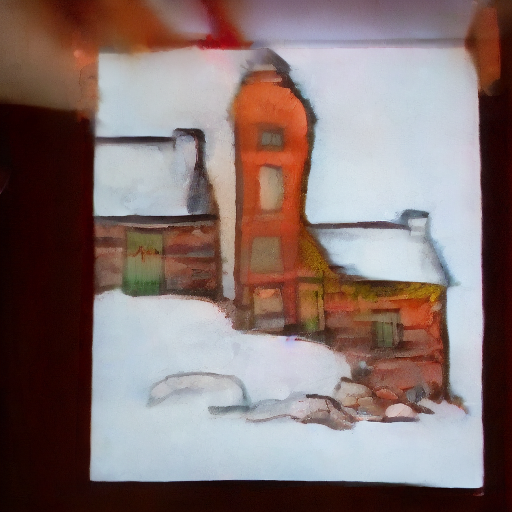
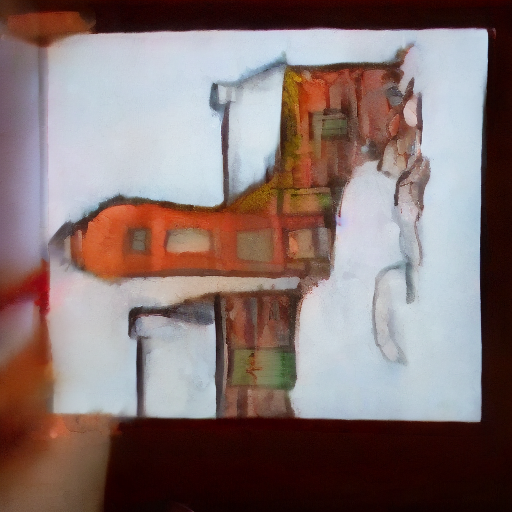

In [ ]:
#@title #Generate Images with Fourier denoising: average the noise of two views, rotation
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    percent = 40


    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample
            if i>199:
              # main idea: at start, strong denoising(cut relatively large portion of DFT coeffs);
              # as steps go further, weaker denoising(keep most of DFT coeffs)
              if i%20 == 0:
                if i%100==0:
                  percent = percent+10
                  print(i)
                  print(percent)
                latents = fourier_denoising_channelwise(latents[0], percent)
                latents = torch.unsqueeze(latents, dim=0)


# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])


0


<ipython-input-16-5deaf767d2b7>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

200
94
300
88
400
82


,

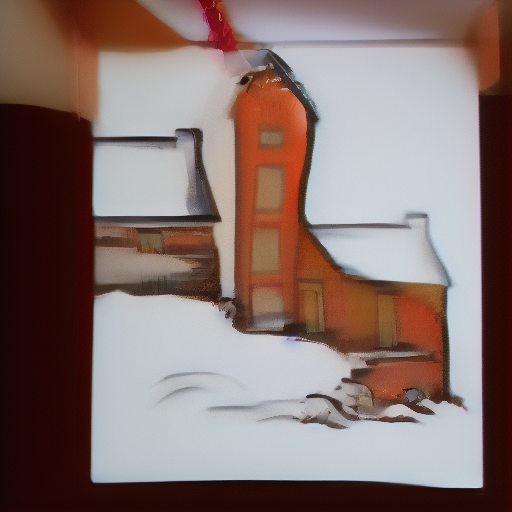
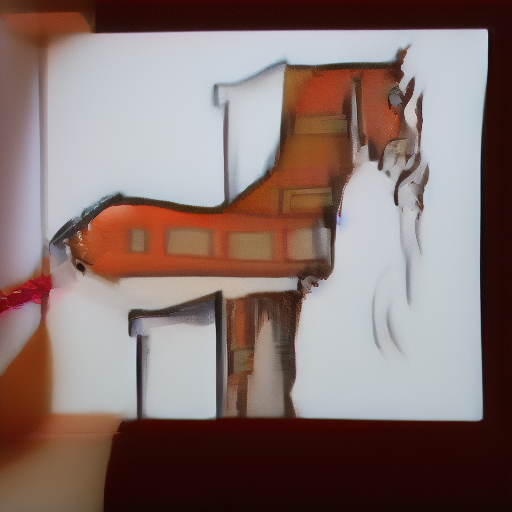

In [ ]:
#@title #Generate Images with Wavelet denoising: average the noise of two views, rotation
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    percent = 100

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample
            if i>199:
              # main idea: at start, weak denoising(cut small portion of DWT coeffs);
              # as steps go further, strong denoising(cut more of DWT coeffs)
              if i%20 == 0:
                if i%100==0:
                  percent = percent-6
                  print(i)
                  print(percent)
                  latents = wavelet_process(latents[0], percent/100) # wavelet denoising
                  latents = torch.unsqueeze(latents, dim=0)


# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])



# Generate Images with TV regularization: average the noise of two views, rotation

0


<ipython-input-17-5208ce954928>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

200
0.18
300
0.09
400
0.045


,

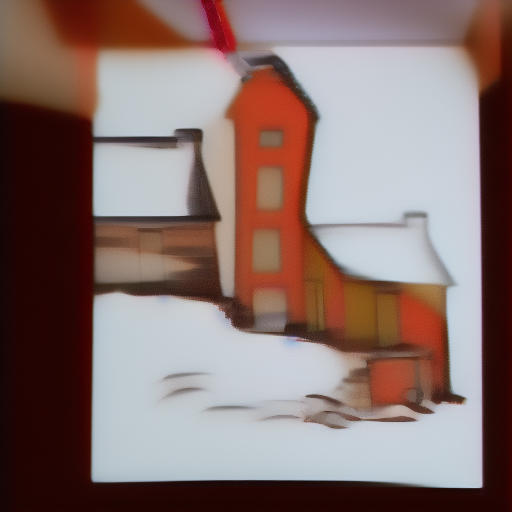
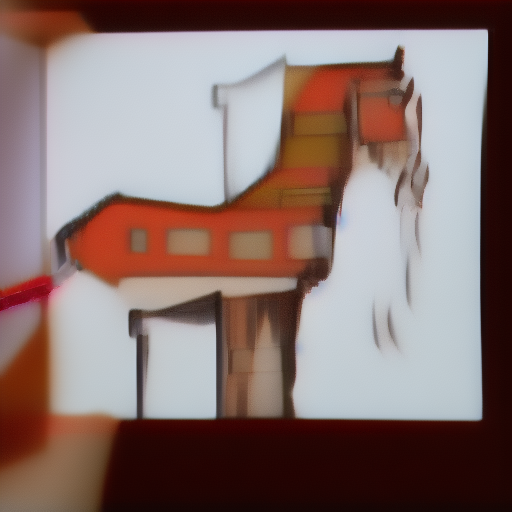

In [ ]:
#@title #Generate Images with TV regularization: average the noise of two views, rotation
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    reg = 0.36

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample
            if i>199:
              # main idea: at start, strong penalty on total variance(TV)
              # as steps go further, decrease the penalty on TV and hence decrease the scale of denoising
              if i%20 == 0:
                if i%100==0:
                  reg = reg/2
                  print(i)
                  print(reg)
                  latents = TV_reg_process(latents, reg) # TV Reg denoising


# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

